# Import dependencies and load data 

In [82]:
import warnings

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, KFold, RandomizedSearchCV, cross_validate, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor

warnings.filterwarnings("ignore")

%matplotlib inline
pd.options.display.float_format = "{:.2f}".format

In [3]:
df = pd.read_csv("../dataset/synthetic_ride_data.csv")
df.shape

(10000, 20)

In [4]:
df.sample(10)

,ride_id,distance_km,duration_min,booking_time,hours,day_of_week,months,pickup_lat,pickup_lon,dropoff_lat,dropoff_lon,weather,traffic_level,available_drivers,area_demand,vehicle_types,user_rating,user_previous_rides,base_price,constrained_price
5859,R005859,5.00,24.00,2025-03-05 20:17:29.337967,20,2,3,21.07,105.77,20.99,105.82,heavy_rain,6,21,30,4_seater_car,4.70,13,100000.00,150000.00
2067,R002067,3.50,17.00,2025-02-22 14:02:21.337967,14,5,2,21.03,105.82,20.99,105.75,sunny,6,30,51,luxury_car,5.00,10,210000.00,210000.00
7940,R007940,3.20,17.00,2025-03-06 17:10:42.337967,17,3,3,21.02,105.84,21.02,105.77,sunny,9,20,28,7_seater_car,5.00,27,96000.00,121000.00
194,R000194,10.10,45.00,2025-03-05 17:00:45.337967,17,2,3,21.05,105.78,21.06,105.80,sunny,7,23,37,4_seater_car,4.30,11,202000.00,252000.00
9881,R009881,7.90,35.00,2025-03-01 17:59:50.337967,17,5,3,21.08,105.80,21.05,105.79,sunny,9,18,81,7_seater_car,4.60,1,237000.00,393000.00
4248,R004248,5.90,25.00,2025-02-21 13:00:42.337967,13,4,2,20.99,105.76,20.99,105.84,sunny,6,22,86,motorbike,4.50,107,59000.00,63000.00
5564,R005564,7.20,34.00,2025-02-21 18:03:05.337967,18,4,2,20.98,105.82,21.00,105.81,sunny,6,22,41,4_seater_car,4.70,2,144000.00,180000.00
237,R000237,3.30,17.00,2025-03-07 12:15:24.337967,12,4,3,20.98,105.81,20.98,105.84,sunny,3,13,17,7_seater_car,4.40,51,99000.00,94000.00
7279,R007279,5.60,25.00,2025-03-07 02:59:13.337967,2,4,3,21.06,105.75,21.02,105.78,heavy_rain,3,23,44,7_seater_car,4.30,13,168000.00,252000.00
6128,R006128,2.10,9.00,2025-02-14 21:37:24.337967,21,4,2,21.01,105.82,21.02,105.80,sunny,2,18,19,4_seater_car,3.90,48,42000.00,40000.00


# Exploratory Data Analysis

In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
distance_km,10000.00,5.09,2.68,0.60,3.20,4.50,6.30,30.10
duration_min,10000.00,24.63,13.25,2.00,15.00,22.00,31.00,156.00
hours,10000.00,11.99,6.38,0.00,7.00,11.00,18.00,23.00
day_of_week,10000.00,2.86,2.04,0.00,1.00,3.00,5.00,6.00
months,10000.00,2.37,0.48,2.00,2.00,2.00,3.00,3.00
pickup_lat,10000.00,21.03,0.03,20.98,21.00,21.02,21.05,21.08
pickup_lon,10000.00,105.80,0.03,105.75,105.77,105.79,105.82,105.85
dropoff_lat,10000.00,21.03,0.03,20.98,21.00,21.02,21.05,21.08
dropoff_lon,10000.00,105.80,0.03,105.75,105.77,105.79,105.82,105.85
traffic_level,10000.00,5.51,1.90,0.00,4.00,6.00,7.00,10.00


### About data distribution
- We can go deeper into **available_drivers** and **user_demand** to find data distribution of true valuable features.
- **duration_min** is right-skewed with a long tail to the right. Most of the data is concentrated in the range of 0-50 minutes.
- **user_rating** to find out status of app user after using service.

### Some potential outliers
- **duration_min** have the max value of 166 minutes, which is higher than 75% of the data about 5 times. So, it is a potential outlier. We can examine this case to find out the reason to improve the service performance.
- **available_drivers** min value is 0, which may cause downtime for app if the only driver is booked or busy.
- **user_demand** max value is 100 which is 2x times of **available_drivers**. It may cause downtime for app if the demand is higher than available drivers. We should find out time or location where this situation happens.
- **base_price** have the max value of 679000, which is higher than 75% of the data about 8 times. So, it is a potential outlier.


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ride_id              10000 non-null  object 
 1   distance_km          10000 non-null  float64
 2   duration_min         10000 non-null  float64
 3   booking_time         10000 non-null  object 
 4   hours                10000 non-null  int64  
 5   day_of_week          10000 non-null  int64  
 6   months               10000 non-null  int64  
 7   pickup_lat           10000 non-null  float64
 8   pickup_lon           10000 non-null  float64
 9   dropoff_lat          10000 non-null  float64
 10  dropoff_lon          10000 non-null  float64
 11  weather              10000 non-null  object 
 12  traffic_level        10000 non-null  int64  
 13  available_drivers    10000 non-null  int64  
 14  area_demand          10000 non-null  int64  
 15  vehicle_types        10000 non-null  

In [7]:
df["booking_time"] = pd.to_datetime(df["booking_time"])

To simplify the analysis, in this notebook, we will pass the timeseries data and focus on the continuous and categorical data.

In [8]:
df.duplicated().sum()

np.int64(0)

In [9]:
df.nunique()

ride_id                10000
distance_km              185
duration_min             104
booking_time            9976
hours                     24
day_of_week                7
months                     2
pickup_lat             10000
pickup_lon             10000
dropoff_lat            10000
dropoff_lon            10000
weather                    3
traffic_level             11
available_drivers         39
area_demand              100
vehicle_types              4
user_rating               24
user_previous_rides      143
base_price               354
constrained_price        641
dtype: int64

In [10]:
X = df.drop(columns=["ride_id", "booking_time", "base_price", "constrained_price"], axis=1)
y = df["constrained_price"]

In [11]:
continuous_features = X.select_dtypes(include=[np.number]).columns
categorical_features = X.select_dtypes(include=["object"]).columns

print(f"Continnuous features: {continuous_features}")
print()
print(f"Catagorical features: {categorical_features}")

Continnuous features: Index(['distance_km', 'duration_min', 'hours', 'day_of_week', 'months',
       'pickup_lat', 'pickup_lon', 'dropoff_lat', 'dropoff_lon',
       'traffic_level', 'available_drivers', 'area_demand', 'user_rating',
       'user_previous_rides'],
      dtype='object')

Catagorical features: Index(['weather', 'vehicle_types'], dtype='object')


## Continuous data

In [12]:
cont_n_plots = len(continuous_features)
cont_n_cols = 4
cont_n_rows = cont_n_plots // cont_n_cols + 1

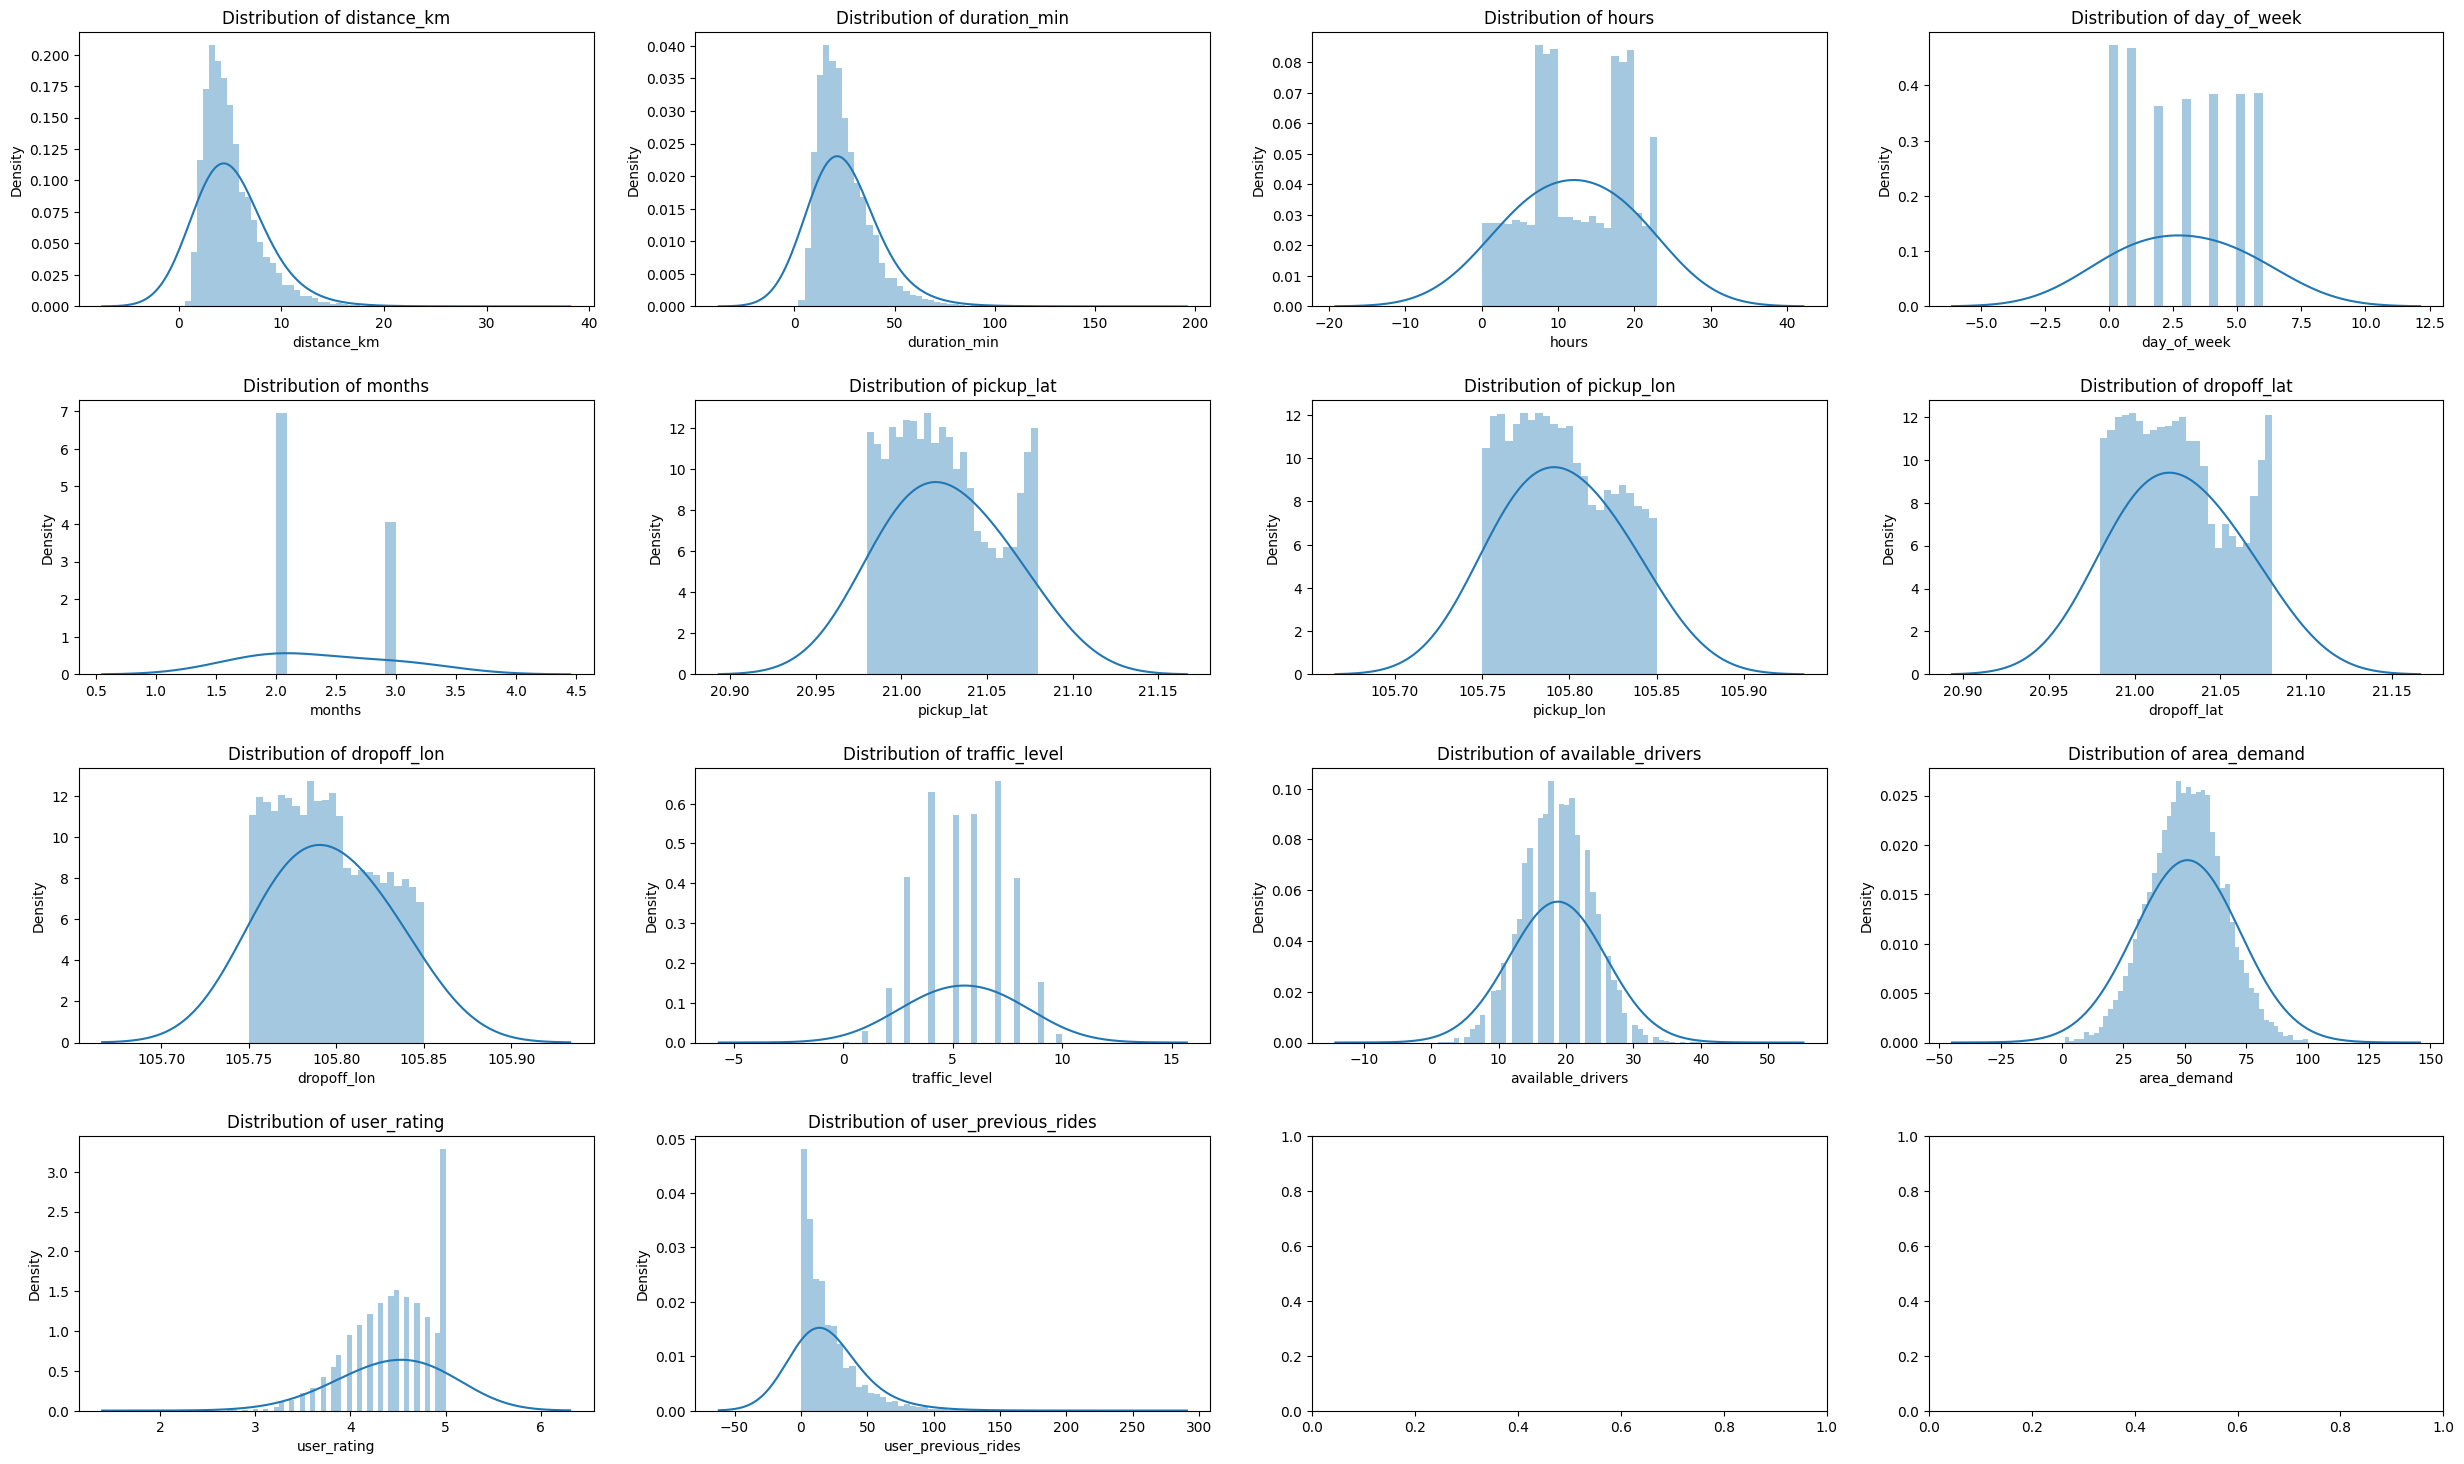

In [13]:
fig, ax = plt.subplots(nrows=cont_n_rows, ncols=cont_n_cols, figsize=(25, 15))
for i in range(cont_n_plots):
    plt.subplot(cont_n_rows, cont_n_cols, i + 1)
    sns.distplot(df[continuous_features[i]], kde_kws={"bw": 1})
    plt.title(f"Distribution of {continuous_features[i]}")

plt.tight_layout(pad=2)

### Insights
Allmost of features have a normal distribution except for **distance_km**, **duration_min**, **user_rating** and **user_demand**.
- **distance_km** is being right-skewed with a long tail to the right with positive values, which can be log normal distribution. Most of the data is concentrated in the range of 0-10 km but there are some trips with a distance of 30 - 40 km.
- **duration_min** have similar right-skewed pattern with **distance_km**(out of 150 minutes) and values are positive. It's make sense with the long distance above. We can try apply *log transformation* to make it normal distribution later.
- there are two peaks in **hour** distribution. We can go deeper to find out the reason.
- **user_rating** is right-skewed with a long tail to the right. Most of the data is concentrated in the range of 4.5 - 5.0. So, the service is pretty good.
- in **user_previous_rides** feature, the distribution is right-skewed with a long tail to the right with all positive values. Most of the data is concentrated in the range of 0-10 rides when almost users are new users (0 is the majority).
- number of user booked a ride in Monday and Tuesday are higher than other days a little bit.

Besides, we still need to go deeper in 
- **traffic_level**: to find the most common traffic level.
- **available_drivers**: Why are there discontinuous values ​​in the plot?


<Axes: xlabel='traffic_level', ylabel='Count'>

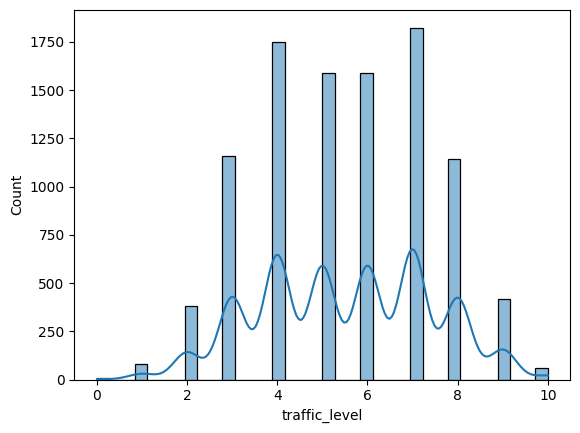

In [14]:
sns.histplot(df["traffic_level"], kde=True)

So, 4 is the most common traffic level. It is a good sign for the service.

<Axes: xlabel='available_drivers', ylabel='Count'>

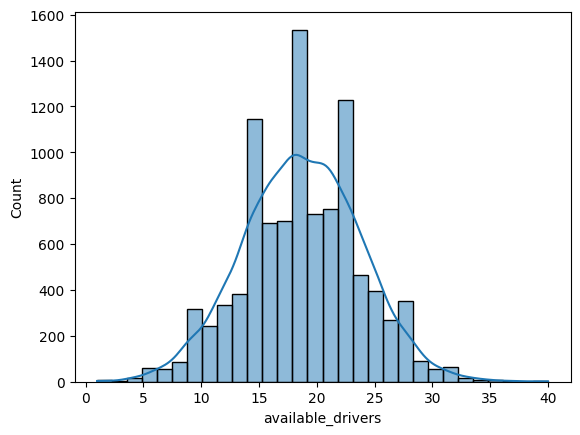

In [15]:
sns.histplot(df["available_drivers"], kde=True, bins=30)

The synthetic data is generated with some variations in the original data by this code 
```
available_drivers = np.clip(np.random.normal(20, 5, n_samples) - peak_hour_effect / 2, 1, 50).astype(int)
```
So, some values of **available_drivers** are not continuous. 

([<matplotlib.axis.XTick at 0x7003b806ad00>,
 [Text(0, 0, '0'),
  Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6'),
  Text(7, 0, '7'),
  Text(8, 0, '8'),
  Text(9, 0, '9'),
  Text(10, 0, '10'),
  Text(11, 0, '11'),
  Text(12, 0, '12'),
  Text(13, 0, '13'),
  Text(14, 0, '14'),
  Text(15, 0, '15'),
  Text(16, 0, '16'),
  Text(17, 0, '17'),
  Text(18, 0, '18'),
  Text(19, 0, '19'),
  Text(20, 0, '20'),
  Text(21, 0, '21'),
  Text(22, 0, '22'),
  Text(23, 0, '23')])

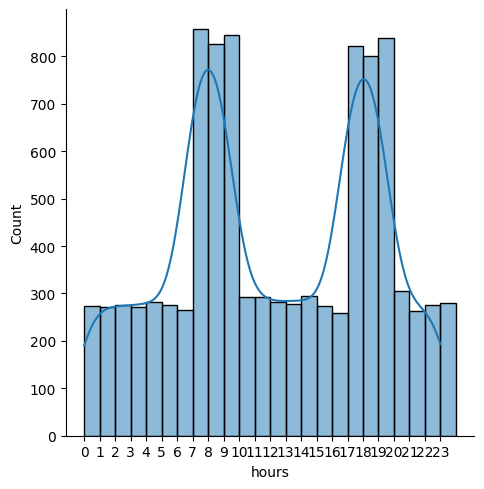

In [16]:
sns.displot(df["hours"], kde=True, bins=range(0, 25))
plt.xticks(
    range(0, 24),
)

## Categorical data

In [17]:
cat_n_plots = len(categorical_features)
cat_n_rows = 1
cat_n_cols = 2

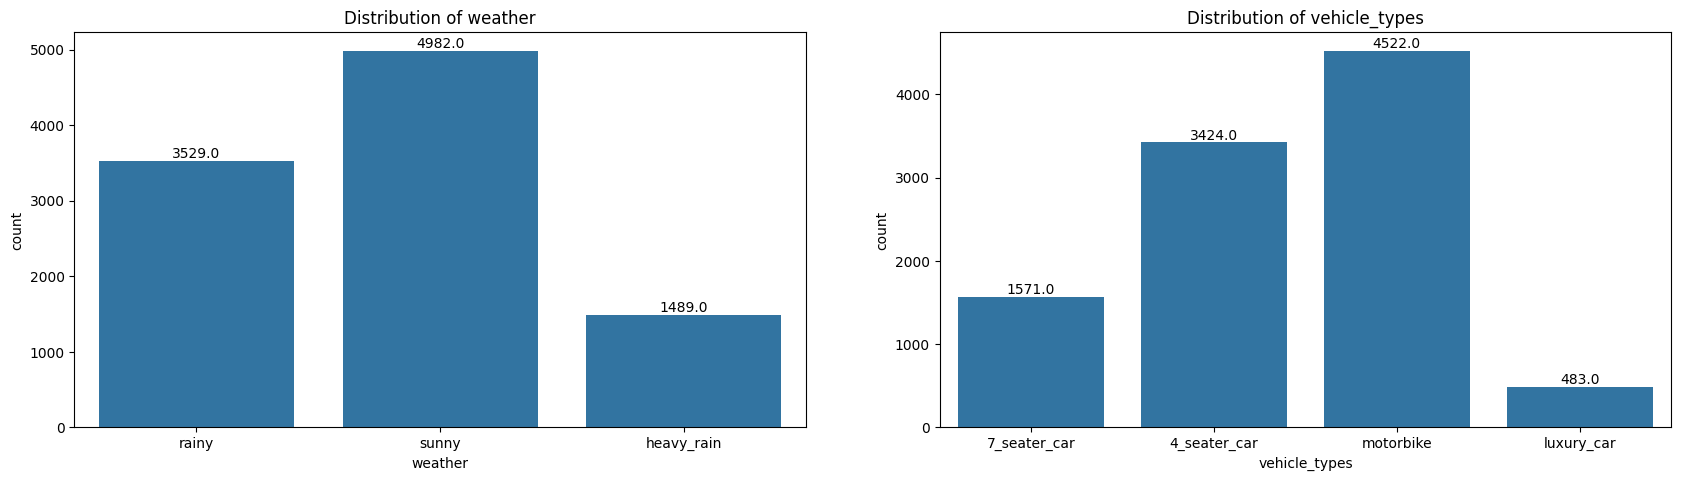

In [18]:
fig, ax = plt.subplots(nrows=cat_n_rows, ncols=cat_n_cols, figsize=(18, 6))
for i in range(cat_n_plots):
    plt.subplot(
        cat_n_rows,
        cat_n_cols,
        i + 1,
    )
    ax = sns.countplot(df, x=categorical_features[i])
    plt.title(f"Distribution of {categorical_features[i]}")

    for rect in ax.patches:
        ax.text(rect.get_x() + rect.get_width() / 2, rect.get_height(), rect.get_height(), ha="center", va="bottom")

plt.tight_layout(pad=5)

### Insights:
- Percentage of rides booked in sunny day is much higher than other weather conditions that can easily be explained by the fact that sunny days are more common than other weather conditions.
- People tend to book a motorbike and 4 seater car.

## Outliers detection and treatment:

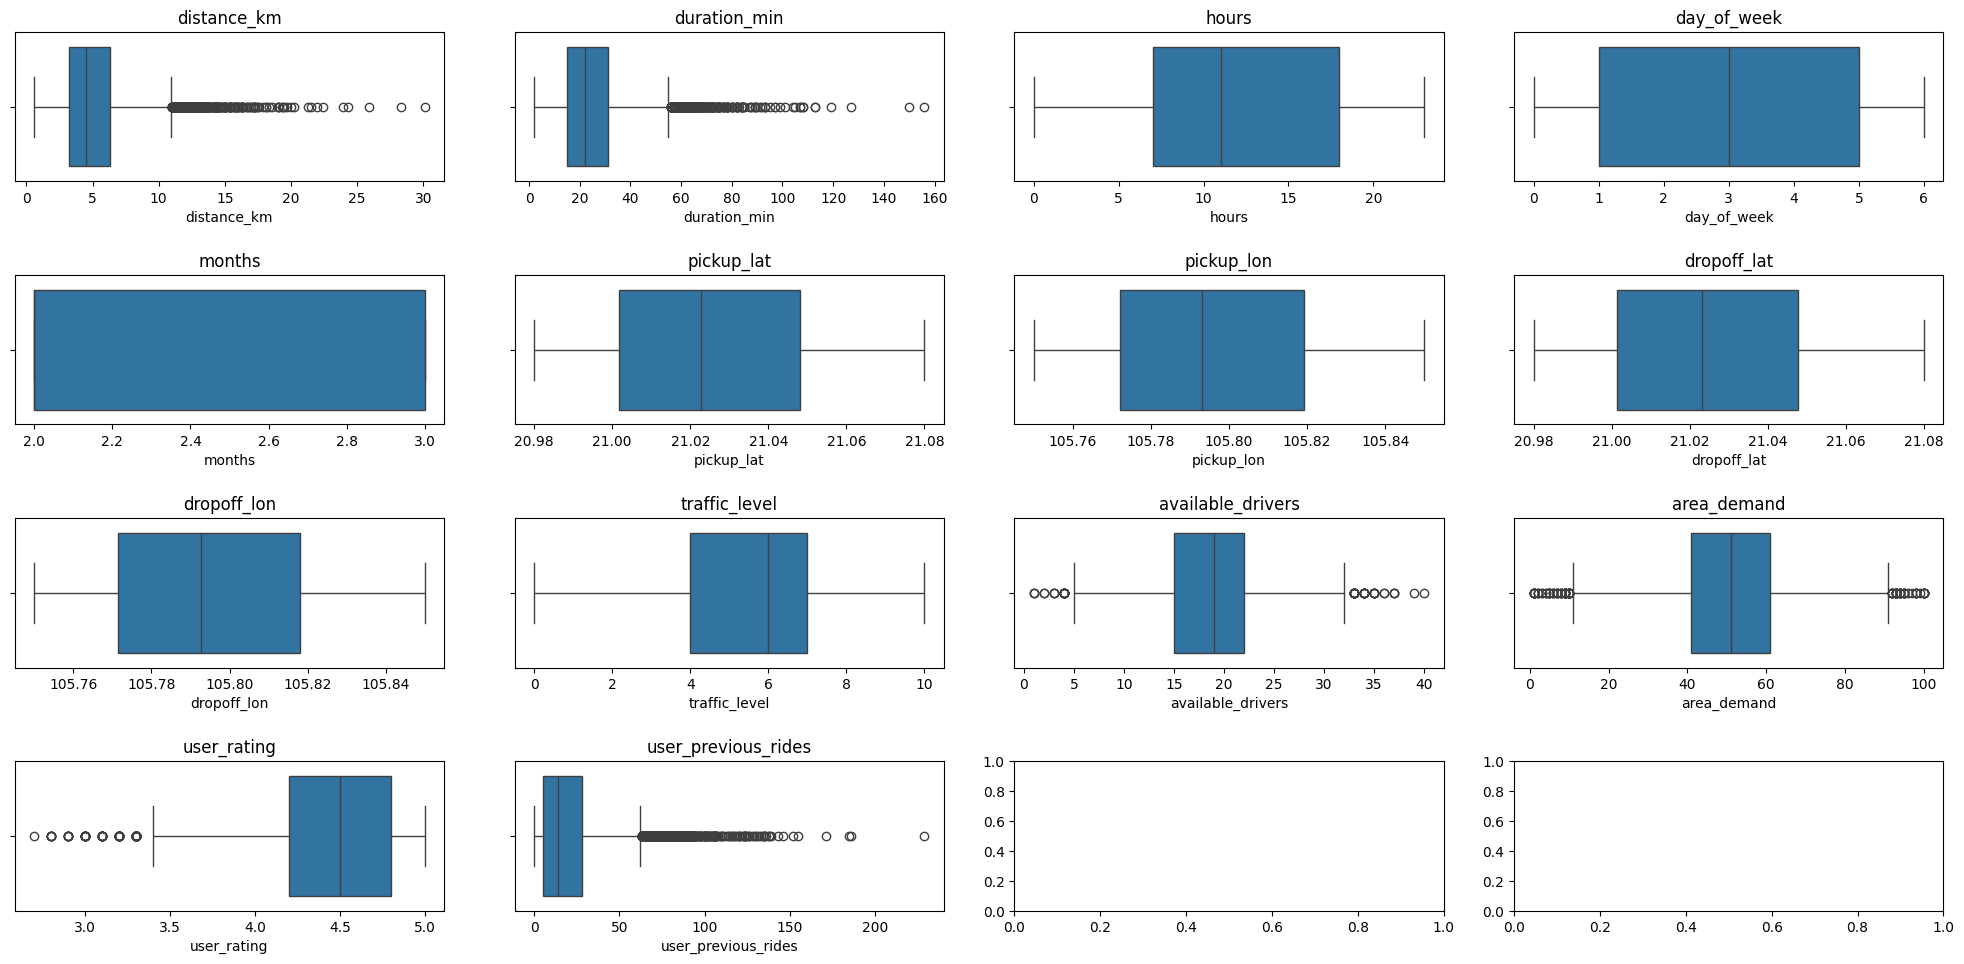

In [19]:
fig, ax = plt.subplots(nrows=cont_n_rows, ncols=cont_n_cols, figsize=(20, 10))
for i in range(cont_n_plots):
    plt.subplot(cont_n_rows, cont_n_cols, i + 1)
    sns.boxplot(df[continuous_features[i]], orient="h")
    plt.title(continuous_features[i])
    plt.tight_layout(pad=2)

There are some potential outliers in distance_km, duration_min, available_drivers, user_demand, user_rating and user_previous_rides. We can use IQR method to detect and treat these outliers.
Especially in **duration_min** and **distance_km**, we can use the log transformation to reduce the skewness of the data.

In [20]:
df_test = df.copy(deep=True)
df_test["distance_km"] = np.log1p(df_test["distance_km"])
# df_test['duration_min'] = np.log1p(df_test['duration_min'])

<Axes: xlabel='distance_km'>

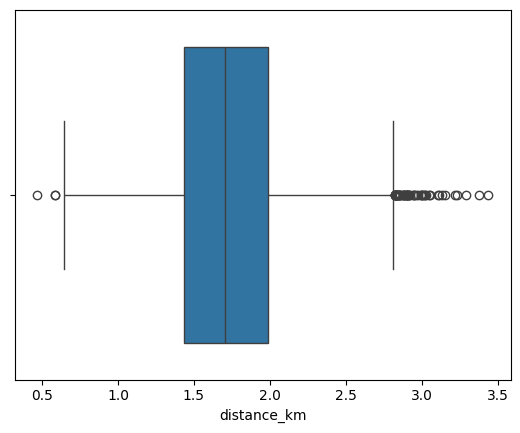

In [21]:
sns.boxplot(df_test["distance_km"], orient="h")

## Feature with target variable:

In [22]:
feature_in_use = continuous_features.tolist() + categorical_features.tolist()
feature_in_use = [
    feature for feature in feature_in_use if feature not in ["pickup_lat", "pickup_lon", "dropoff_lat", "dropoff_lon"]
]
len(feature_in_use)

12

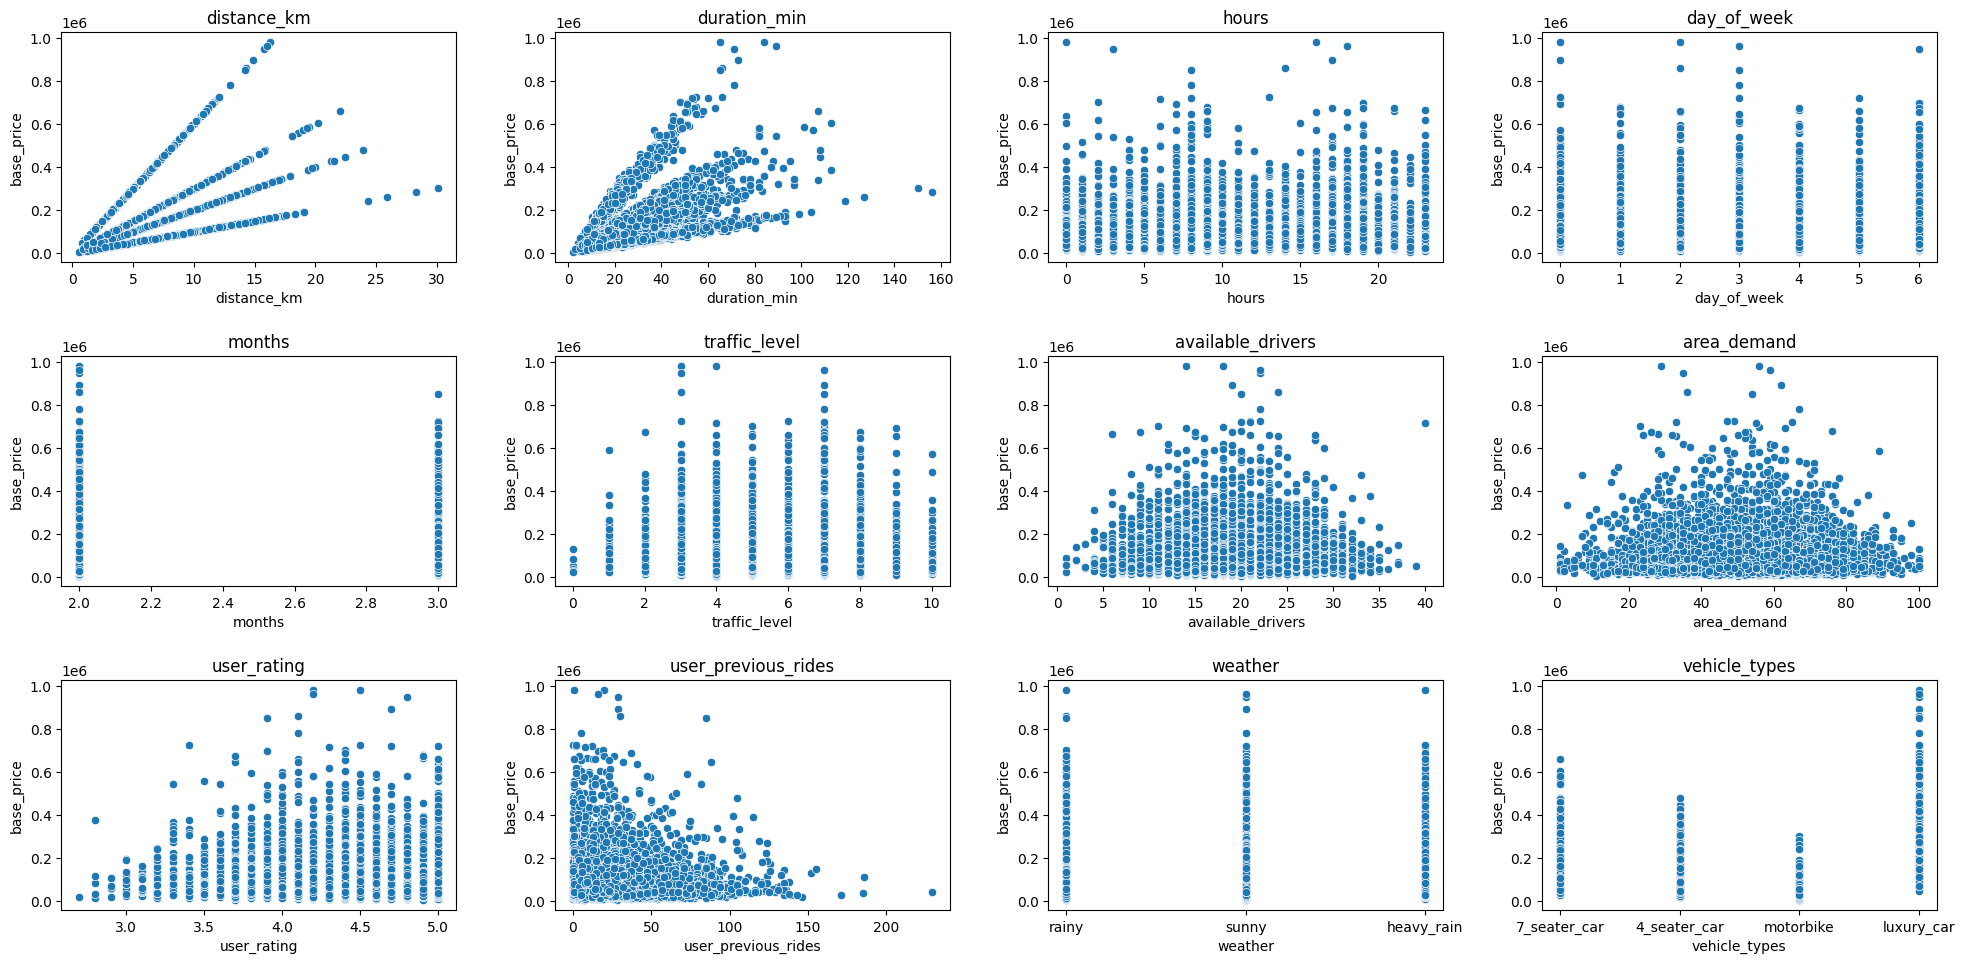

In [23]:
fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(20, 10))
for i, feat in enumerate(feature_in_use):
    plt.subplot(3, 4, i + 1)
    sns.scatterplot(data=df, x=df[feat], y=df["base_price"])
    plt.title(feat)
    plt.tight_layout(pad=2)

## Correlation matrix 

In [24]:
corr_features = [*feature_in_use, "base_price", "constrained_price"]

corr_features = [feature for feature in corr_features if feature not in ["vehicle_types", "weather"]]
corr_features

['distance_km',
 'duration_min',
 'hours',
 'day_of_week',
 'months',
 'traffic_level',
 'available_drivers',
 'area_demand',
 'user_rating',
 'user_previous_rides',
 'base_price',
 'constrained_price']

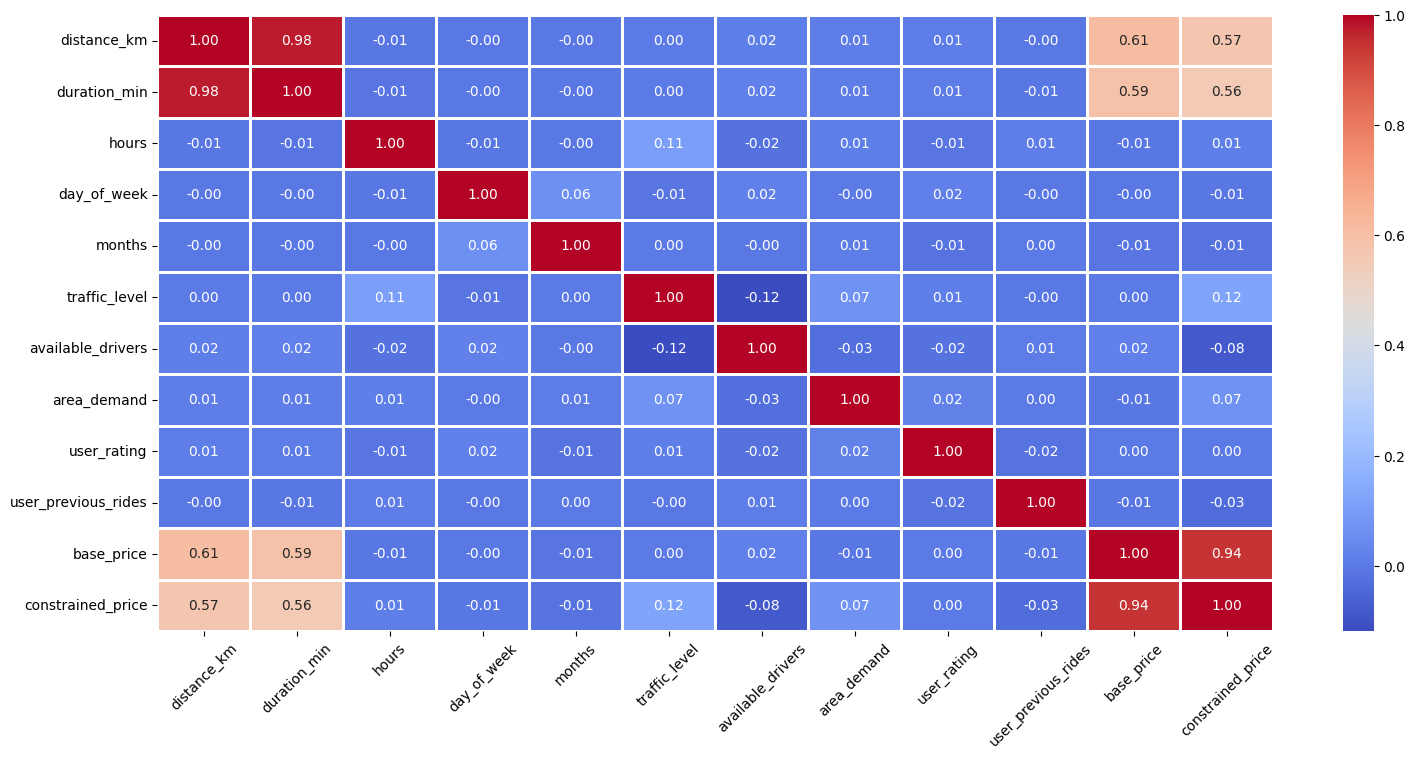

In [25]:
# corr_features = continuous_features.tolist() + ['constrained_price']
correlation = df[corr_features].corr()

plt.figure(figsize=(18, 8))
sns.heatmap(correlation, annot=True, cmap="coolwarm", fmt=".2f", linewidths=2)
plt.xticks(rotation=45)
plt.show()

Although the correlation matrix shows that **base_price** is highly correlated with **constrained_price**, we should not use it because **base_price** is calculated from **distance_km** and **vehicle_types**. Furthermore, in a real-world environment, **base_price** should be calculated from the inputs rather than a feature available in inference.

In [26]:
# Get correlations with 'constrained_price' (ignoring self-correlation)
corr_target = correlation["constrained_price"].drop("constrained_price")

top4_const = corr_target.sort_values(ascending=False).head(4)
bottom4_const = corr_target.sort_values(ascending=True).head(4)

print("Top 4 highest correlation with constrained_price:")
print(top4_const)
print("\nTop 4 lowest correlation with constrained_price:")
print(bottom4_const)

Top 4 highest correlation with constrained_price:
base_price      0.94
distance_km     0.57
duration_min    0.56
traffic_level   0.12
Name: constrained_price, dtype: float64

Top 4 lowest correlation with constrained_price:
available_drivers     -0.08
user_previous_rides   -0.03
months                -0.01
day_of_week           -0.01
Name: constrained_price, dtype: float64


# Feature Engineering

- Data distribution of **Distance_km** and **Duration_min** now seems to be normal distribution after applying log transformation.
- **user_previous_rides** is now better and nearly normal distribution after applying log transformation.

In [27]:
print(continuous_features)
print(categorical_features)

Index(['distance_km', 'duration_min', 'hours', 'day_of_week', 'months',
       'pickup_lat', 'pickup_lon', 'dropoff_lat', 'dropoff_lon',
       'traffic_level', 'available_drivers', 'area_demand', 'user_rating',
       'user_previous_rides'],
      dtype='object')
Index(['weather', 'vehicle_types'], dtype='object')


In [28]:
X = df.drop(columns=["ride_id", "booking_time", "base_price", "constrained_price"], axis=1)
y = df["constrained_price"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(8000, 16) (2000, 16) (8000,) (2000,)


In [29]:
numerical_transformer = Pipeline(steps=[("scaler", StandardScaler())])

categorical_transformer = Pipeline(steps=[("encoder", OneHotEncoder(drop="first", sparse_output=False))])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numerical_transformer, continuous_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

In [30]:
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

In [31]:
cat_feat_names = (
    preprocessor.named_transformers_["cat"].named_steps["encoder"].get_feature_names_out(categorical_features)
)
feature_names = np.concatenate([continuous_features, cat_feat_names])
X_train_transformed = pd.DataFrame(X_train_transformed, columns=feature_names)
X_test_transformed = pd.DataFrame(X_test_transformed, columns=feature_names)

X_train_transformed

,distance_km,duration_min,hours,day_of_week,months,pickup_lat,pickup_lon,dropoff_lat,dropoff_lon,traffic_level,available_drivers,area_demand,user_rating,user_previous_rides,weather_rainy,weather_sunny,vehicle_types_7_seater_car,vehicle_types_luxury_car,vehicle_types_motorbike
0,0.26,0.25,0.79,-0.92,-0.76,-0.95,1.36,-0.68,0.81,0.78,-0.74,1.78,-1.26,2.57,0.00,1.00,0.00,0.00,1.00
1,-0.85,-0.95,0.79,1.53,-0.76,-0.47,-1.59,0.54,-0.19,1.31,1.23,-0.84,-0.57,1.55,0.00,0.00,0.00,0.00,0.00
2,-0.15,-0.20,-1.88,-0.43,-0.76,-0.55,-0.25,1.07,-1.29,0.25,-1.13,-0.51,-1.49,-0.29,1.00,0.00,0.00,1.00,0.00
3,-0.48,-0.42,0.94,0.06,-0.76,-0.07,-0.41,-1.12,-0.84,0.78,-1.92,-1.36,-0.34,-0.49,1.00,0.00,0.00,0.00,1.00
4,4.55,4.95,-0.16,-0.43,1.31,1.78,0.10,-1.34,-0.65,-0.80,0.24,0.27,-1.72,0.78,1.00,0.00,0.00,0.00,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,0.22,0.40,-1.73,0.55,-0.76,1.64,-0.74,-0.66,-1.01,-1.33,-0.93,-0.12,0.12,-0.88,0.00,1.00,0.00,0.00,1.00
7996,0.96,1.44,1.10,1.53,-0.76,-1.00,1.81,1.79,1.90,0.78,-0.54,0.67,-1.95,0.73,0.00,1.00,0.00,0.00,1.00
7997,0.34,0.32,1.10,0.06,-0.76,1.46,-0.08,-1.14,1.11,0.78,-1.52,0.34,1.27,0.92,0.00,1.00,0.00,0.00,1.00
7998,-0.52,-0.35,0.63,-1.41,-0.76,-0.45,-0.19,-1.10,0.86,-0.27,-0.15,-0.44,0.81,1.26,0.00,1.00,0.00,0.00,0.00


# Modeling

## Create baseline model

In [44]:
models = {
    "LinearRegression": LinearRegression(),
    "RandomForestRegressor": RandomForestRegressor(random_state=42),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=42),
    "DecisionTreeRegressor": DecisionTreeRegressor(random_state=42),
    "XGBRegressor": XGBRegressor(random_state=42),
}

In [45]:
scoring = {
    "R2": make_scorer(r2_score),
    "MAE": make_scorer(mean_absolute_error),
    "RMSE": make_scorer(lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred))),
}

In [46]:
results = []

kf = KFold(n_splits=10, shuffle=True, random_state=42)

for name, model in models.items():
    print(f"Training {name}...")

    model_pipeline = Pipeline(steps=[("preprocessor", preprocessor), ("model", model)])

    print(f"Cross validating {name}...")
    scores = cross_validate(model_pipeline, X, y, cv=kf, scoring=scoring, return_train_score=True, n_jobs=-1)
    print(f"Cross Validating done!  Scores: {scores}")

    results.append({
        "Model": name,
        "R2": scores["test_R2"].mean(),
        "MAE": scores["test_MAE"].mean(),
        "RMSE": scores["test_RMSE"].mean(),
        "Score Time": scores["score_time"].mean(),
        "Train_R2": scores["train_R2"].mean(),
        "Train MAE": scores["train_MAE"].mean(),
        "Train_RMSE": scores["train_RMSE"].mean(),
        "Fit Time": scores["fit_time"].mean(),
    })

    print(f"Training {name} done!")
    print()

Training LinearRegression...
Cross validating LinearRegression...
Cross Validating done!  Scores: {'fit_time': array([0.02275157, 0.01577187, 0.01525164, 0.02127671, 0.01794505,
       0.02159977, 0.01555753, 0.02218127, 0.01521707, 0.01403284]), 'score_time': array([0.00576758, 0.00416803, 0.00380683, 0.00603032, 0.00440049,
       0.00583577, 0.00419569, 0.0059495 , 0.00362706, 0.00392532]), 'test_R2': array([0.8244724 , 0.80985639, 0.8070804 , 0.81483259, 0.82665804,
       0.84365934, 0.82614798, 0.82561364, 0.81300308, 0.82104379]), 'train_R2': array([0.82269035, 0.82440264, 0.82470093, 0.82369982, 0.82230892,
       0.8203238 , 0.82252721, 0.82255048, 0.82360899, 0.82294224]), 'test_MAE': array([30641.55720831, 29695.22297153, 29731.61229609, 31085.91095524,
       29623.33000962, 32424.9453842 , 29529.40923809, 30976.05038078,
       28866.40573578, 30199.52302031]), 'train_MAE': array([30071.15508562, 30158.36600226, 30133.30874452, 30253.75217118,
       30298.12663575, 29875.

In [47]:
results_df = pd.DataFrame(results)
results_df.sort_values(by="R2", ascending=False)

,Model,R2,MAE,RMSE,Score Time,Train_R2,Train MAE,Train_RMSE,Fit Time
4,XGBRegressor,0.97,7534.85,20470.69,0.01,1.00,2418.51,3414.16,1.22
2,GradientBoostingRegressor,0.96,11324.33,23836.07,0.01,0.98,9977.14,18325.24,2.32
1,RandomForestRegressor,0.96,11669.53,26688.51,0.03,0.99,4367.83,10190.04,7.04
3,DecisionTreeRegressor,0.91,17251.70,38627.26,0.00,1.00,0.00,0.00,0.13
0,LinearRegression,0.82,30277.40,53954.61,0.00,0.82,30206.35,53850.59,0.02


- R2 score: near 1 is better.
- RMSE and MSE: near 0 is better. 

**Model evaluation:**
- **XGBoost Regressor** has the best performance with R2 score of 0.97, RMSE ~ 20470 and MAE ~ 7535.
- **Gradient Boosting Regressor** and **Random Forest Regressor** can be considered to use as a baseline model with second and third best performance.
- **Decision Tree Regressor**: Overfitting
- **Linear Regression**: Fastest but not good performance.

So, we can consider using **XGBoost Regressor**, **Gradient Boosting Regressor** or **Random Forest Regression** as a baseline model.

In [49]:
models = {
    "RandomForestRegressor": RandomForestRegressor(random_state=42),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=42),
    "XGBRegressor": XGBRegressor(random_state=42),
}

In [50]:
param_distributions = {
    "RandomForestRegressor": {
        "model__n_estimators": [50, 100, 200, 300],
        "model__max_depth": [5, 15, 30],
        "model__min_samples_split": [2, 10, 20],
        "model__min_samples_leaf": [1, 4, 8, 16],
        "model__max_features": ["auto", "sqrt", "log2"],
        "model__bootstrap": [True, False],
    },
    "GradientBoostingRegressor": {
        "model__n_estimators": [50, 100, 200, 300],
        "model__learning_rate": [0.001, 0.1, 0.3],
        "model__max_depth": [5, 15, 30],
        "model__min_samples_split": [2, 10, 20],
        "model__min_samples_leaf": [1, 4, 8, 16],
        "model__max_features": ["auto", "sqrt", "log2"],
    },
    "XGBRegressor": {
        "model__n_estimators": [50, 100, 200, 300, 500, 1000],
        "model__learning_rate": [0.001, 0.05, 0.1, 0.3],
        "model__max_depth": [5, 15, 30],
        "model__min_child_weight": [1, 4, 8, 16],
        "model__subsample": [0.5, 0.7, 1.0],
        "model__colsample_bytree": [0.5, 0.7, 1.0],
    },
}

In [57]:
best_models = {}

for name, model in models.items():
    print(f"Tuning {name}...")

    model_pipeline = Pipeline(steps=[("preprocessor", preprocessor), ("model", model)])

    random_search = RandomizedSearchCV(
        model_pipeline,
        param_distributions[name],
        n_iter=10,
        scoring=scoring,
        refit="R2",  # choose R2 as main metric to optimize
        cv=kf,
        n_jobs=-1,
        random_state=42,
        return_train_score=True,
    )

    random_search.fit(X_train, y_train)

    best_models[name] = random_search.best_estimator_
    print(f"✅ Best Params for {name}: {random_search.best_params_}")
    print(f"✅ Best R2 Score: {random_search.best_score_}\n")

best_model_name = max(best_models, key=lambda name: best_models[name].score(X_test, y_test))
best_model = best_models[best_model_name]

y_pred = best_model.predict(X_test)
print(f"Best Model: {best_model_name}")
print(f"Test R2 Score: {best_model.score(X_test, y_test)}")

Tuning RandomForestRegressor...
✅ Best Params for RandomForestRegressor: {'model__n_estimators': 100, 'model__min_samples_split': 2, 'model__min_samples_leaf': 1, 'model__max_features': 'sqrt', 'model__max_depth': 15, 'model__bootstrap': False}
✅ Best R2 Score: 0.9460787862221582

Tuning GradientBoostingRegressor...
✅ Best Params for GradientBoostingRegressor: {'model__n_estimators': 50, 'model__min_samples_split': 20, 'model__min_samples_leaf': 16, 'model__max_features': 'log2', 'model__max_depth': 30, 'model__learning_rate': 0.1}
✅ Best R2 Score: 0.9653745335280559

Tuning XGBRegressor...
✅ Best Params for XGBRegressor: {'model__subsample': 1.0, 'model__n_estimators': 500, 'model__min_child_weight': 8, 'model__max_depth': 5, 'model__learning_rate': 0.05, 'model__colsample_bytree': 0.7}
✅ Best R2 Score: 0.9832399995317852

Best Model: XGBRegressor
Test R2 Score: 0.9808096492096683


In [67]:
tuned_models = {
    "RandomForestRegressor": RandomForestRegressor(
        **best_models["RandomForestRegressor"].named_steps["model"].get_params()
    ),
    "GradientBoostingRegressor": GradientBoostingRegressor(
        **best_models["GradientBoostingRegressor"].named_steps["model"].get_params()
    ),
    "XGBRegressor": XGBRegressor(**best_models["XGBRegressor"].named_steps["model"].get_params()),
}

In [80]:
param_grid = {
    "model__n_estimators": [450, 500, 550, 600],
    "model__learning_rate": [0.03, 0.05, 0.08],
    "model__max_depth": [3, 5, 7],
    "model__min_child_weight": [6, 8, 10],
}

In [81]:
grid_search = GridSearchCV(
    best_model,
    param_grid=param_grid,
    scoring=scoring,
    refit="R2",  # choose R2 as main metric to optimize
    cv=kf,
    n_jobs=-1,
    return_train_score=True,
)

grid_search.fit(X_train, y_train)

best_xgb = grid_search.best_estimator_
print(f"✅ Best Params for XGBRegression: {grid_search.best_params_}")
print(f"✅ Best R2 Score: {grid_search.best_score_}\n")

# Eval
y_pred = best_xgb.predict(X_test)
print(f"Test R2 Score: {r2_score(y_test, y_pred)}")
print(f"Test MSE: {mean_squared_error(y_test, y_pred)}")
print(f"Test MAE: {mean_absolute_error(y_test, y_pred)}")

✅ Best Params for XGBRegression: {'model__learning_rate': 0.05, 'model__max_depth': 5, 'model__min_child_weight': 10, 'model__n_estimators': 600}
✅ Best R2 Score: 0.9837316411142376

Test R2 Score: 0.9817498049011886
Test MSE: 317815017.0331217
Test MAE: 6042.295320800781


In [89]:
best_model.get_params().get("model")

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=8, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [90]:
joblib.dump(best_xgb, "../models/xgb.pkl")
joblib.dump(models["RandomForestRegressor"], "../models/random_forest.pkl")
joblib.dump(models["GradientBoostingRegressor"], "../models/gradient_boosting.pkl")

['../models/gradient_boosting.pkl']